# Project 1: Exploratory Data Analysis of Movies
Amelia Dahm & Khyatee Desai

## Import Python Libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from bs4 import BeautifulSoup
%matplotlib inline

## Read in CSV Files

In [2]:
movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')

# Question 1: Which Movies Genres are Most Successful?
The purpose of exploring this question was to investigate which movie genres are most successful. For this question, we wanted to explore metrics of "success" beyond just gross revenue. Academy Award nominations are widely accepted as a reliable measure of a film's quality, so we decided to include Oscar Nomination data as a measure of "success" in addition to Gross Revenue.<br>If the data shows that certain movie genres tend to recieve more nominations or generate a higher gross revenue, this suggests that "Microsoft" should invest more in producing films of those genres.

## Method:

##  Read in Oscars Dataset
The Oscars dataset contains information on cast, crew, and movie titles of Oscar-nominated films.<br>Source: https://www.kaggle.com/unanimad/the-oscar-award

In [3]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw.head(3)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False


## Get the count of Oscar Nominations per movie

In [4]:
# subset the relevant data from Oscars df. Rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)
oscars.head(3)

,title,person,category,oscar_noms
0,The Noose,Richard Barthelmess,ACTOR,1
1,The Last Command,Emil Jannings,ACTOR,2
2,A Ship Comes In,Louise Dresser,ACTRESS,1


## Unstack the Genre values
Genres were originally formatted as a comma-delimited string (ie 'Action, Crime, Drama'.) We reformatted this to give each genre its own row in the table.

In [5]:
# Unstacking Genre column to create individual rows (takes a while to run cell)
genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('primary_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['primary_title', 'genres']
genre_unstack.head(3)

,primary_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama


## Merge Oscars table with Genre table

In [6]:
oscar_genre = oscars.merge(genre_unstack, how = 'left', left_on='title', right_on='primary_title').drop('primary_title', axis=1)
oscar_genre.head(3)

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN


## Clean Gross Revenue Table

In [7]:
# subset relevant data, change strings to floats
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','').astype(float)
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross
movie_gross.head(3)

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08


 ## Clean Budgets Table

In [8]:
# subset relevant data, change strings to floats
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'total_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['total_gross'] = budgets['total_gross'].str.replace('$','')
budgets['total_gross'] = budgets['total_gross'].str.replace(',','').astype(float)
budgets.head(3)

,title,production_budget,domestic_gross,total_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08


## Concatenate Gross Revenue Table with Budgets Table

In [9]:
# concat gross and budget tables, create columns for total_gross and Return on Investment, drop duplicate rows
budget_concat = pd.concat([movie_gross, budgets], sort=True)
budget_concat['roi'] = (((budget_concat.total_gross - budget_concat.production_budget)/budget_concat.production_budget)* 100).round(2)
budget_concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
budget_concat.sample(3)

,domestic_gross,foreign_gross,production_budget,title,total_gross,roi
154,412563408.0,NaN,150000000.0,Wonder Woman,821133378.0,447.42
2807,104000000.0,76600000.0,NaN,Daddy's Home 2,180600000.0,NaN
538,224000.0,4500000.0,NaN,Tucker & Dale Vs. Evil,4724000.0,NaN


## Final Oscar Nominations, Genre, and Budget DataFrame
This is the table used as the starting point for the analysis below. Null values are retained in this table, but dropped below based on the specific metrics being compared.

In [10]:
# subset the oscars table, drop duplicate listings
oscar_df = oscar_genre.loc[:,['title', "oscar_noms", 'genres']]
oscar_df.drop_duplicates(inplace=True)

# merged genre/oscar table with budgets (used Left Join to retain all Oscar data)
oscar_df = oscar_df.merge(budget_concat[['title','production_budget', "total_gross", 'roi']], on='title', how='left').set_index('title')
oscar_df.sort_values('oscar_noms', ascending=False)

,oscar_noms,genres,production_budget,total_gross,roi
title,,,,,
A Star Is Born,25,Romance,NaN,NaN,NaN
A Star Is Born,25,Drama,NaN,NaN,NaN
A Star Is Born,25,Music,NaN,NaN,NaN
Titanic,16,Family,200000000.0,2.208208e+09,1004.10
Titanic,16,Adventure,200000000.0,2.208208e+09,1004.10
...,...,...,...,...,...
Evolution,1,Mystery,80000000.0,9.834193e+07,22.93
Evolution,1,Drama,80000000.0,9.834193e+07,22.93
The Crunch Bird,1,NaN,NaN,NaN,NaN


# Question 1 Analysis 

## Oscar Nominations vs Total Gross Revenue
### Text Analysis here:______

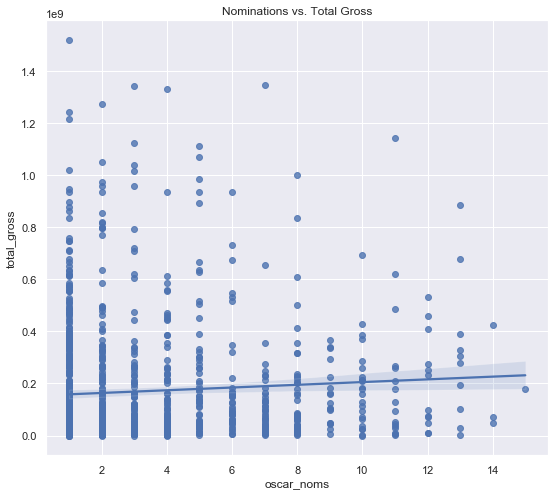

In [105]:
x ='oscar_noms'
y = 'total_gross'

# drop duplicates, nulls values, and 3 outliers with highest Total Gross Revenue (Avatar, Titanic, and Avengers: Infinity War)
noms_vs_budget = oscar_df.loc[:,[x, y]].drop_duplicates().sort_values(y).dropna(subset=['total_gross'])[:-3] 

# sns.set(rc={'figure.figsize':(9,9)});
sns.regplot(x,y, data = noms_vs_budget);
plt.title('Nominations vs. Total Gross');

## Removing Gross Revenue Outliers

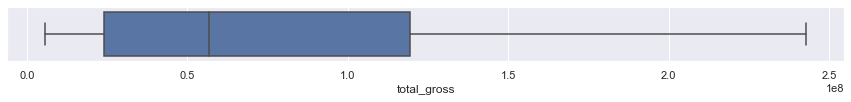

In [129]:
# drop outliers by excluding upper quartile
gross = oscar_df[oscar_df["total_gross"].between(*oscar_df.total_gross.quantile([0.1, 0.75]).tolist())]

# check boxplot to verify outliers are gone
sns.set(rc={'figure.figsize':(15,1)});
sns.boxplot(data=gross, x='total_gross');

## Total Gross Revenue, By Genre
### Text Analysis here:______

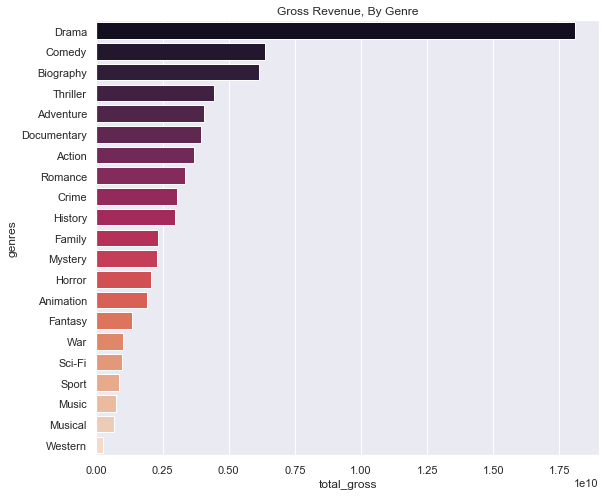

In [131]:
genre_gross = gross.groupby(['genres'])['total_gross'].sum().reset_index().sort_values('total_gross', ascending=False)

sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('total_gross','genres' , data = genre_gross, order= genre_gross['genres'], palette='rocket');
plot.set_title('Gross Revenue, By Genre');

## Oscar Nominations, By Genre
### Text Analysis here:______

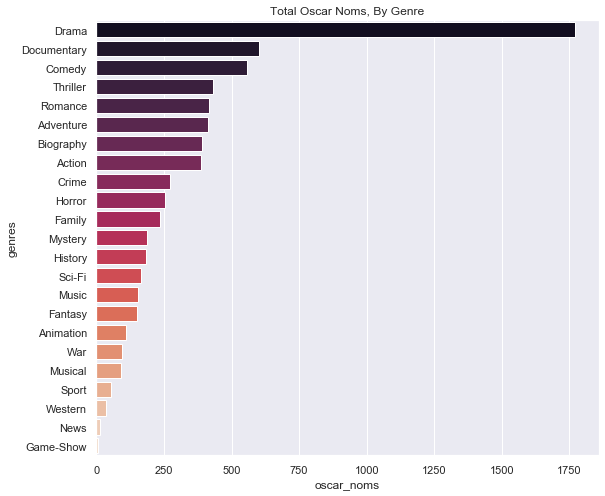

In [96]:
genre_noms = oscar_df.groupby(['genres'])['oscar_noms'].sum().reset_index().sort_values('oscar_noms', ascending=False)


sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('oscar_noms','genres' , data = genre_noms, order= genre_noms['genres'], palette='rocket');
plot.set_title('Total Oscar Noms, By Genre');

## Question 1 Conclusion: 
Add conclusion _________________==================================____________________

# Question 2: How does Trailer Popularity Impact Movie Success?
The purpose of this question is to explore the relationship between a movie's trailer popularity and its Box Office performance. If there is a relationship between the two, this could indicate that movie trailers play a significant role in a movie's marketing efforts, and that "Microsoft" should place a higher importance on investing resources into movie trailers for their future movies.

## Method:

## Read in Movie Trailer CSV
The movie trailer dataset includes movie titles and YouTubeID's corresponding to the film's trailer on YouTube.<br>Source: https://grouplens.org/datasets/movielens/20m-youtube/

In [14]:
# slice year out of title string, merge with budgets table
trailers_raw = pd.read_csv('./zippedData/movie_trailers.zip')
trailers_raw['title'] = trailers_raw['title'].str[:-7]
trailers = trailers_raw.merge(budget_concat, on='title').sort_values('total_gross', ascending=False) #### remove this later
ids = list(trailers["youtubeId"].values[:])
trailers.head()

,youtubeId,movieId,title,domestic_gross,foreign_gross,production_budget,total_gross,roi
2745,5MB3Ea6L-gw,72998,Avatar,760507625.0,NaN,425000000.0,2.776345e+09,553.26
458,dQ7MAigAhas,3404,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
457,2e-eXJ6HgkQ,1721,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
459,yxIVO7P0iig,118916,Titanic,659363944.0,NaN,200000000.0,2.208208e+09,1004.10
2798,tck0UR2ppjg,82452,Frozen,400738009.0,NaN,150000000.0,1.272470e+09,748.31


## Create function to feed in youtube id's of trailers and retrieve view counts

In [15]:
def getViews(youtubeIDs):
    views = []
    for i in youtubeIDs:
        try:
            url = "https://www.youtube.com/watch?v={}".format(i)
            html_page = requests.get(url) 
            soup = BeautifulSoup(html_page.text, 'html.parser')
            script = soup.find_all('script')[32]
            value = re.findall('ewCount":{"simpleText":"([\d,]+) views', str(soup))
            views.append(float(value[0].replace(',','')))
        except:
            views.append(0)
    return views


## Scrape all YouTube Trailers and save as CSV (Warning: takes ~1hr to run)
### Leave this commented out

In [16]:
# trailers['trailer_views'] = getViews(ids)
# trailers.to_csv('zippedData/trailerViews.csv')

# Final Trailer Views vs ROI DataFrame

In [17]:
# sort by trailer views and drop duplicates to keep only trailer with highest views
trailer_df = pd.read_csv('zippedData/trailerViews.csv')
trailer_df = trailer_df.loc[:,['title','youtubeId','production_budget', 'total_gross', 'roi', 'trailer_views']].sort_values('trailer_views', ascending=False)
trailer_df = trailer_df.drop_duplicates(subset= ['title'], keep='first').set_index('title')
trailer_df

,youtubeId,production_budget,total_gross,roi,trailer_views
title,,,,,
Unfaithful,j-V12tL78Mc,50000000.0,1.191145e+08,138.23,117290789.0
Ilo Ilo,ISovsVvX8Bg,NaN,1.156800e+06,NaN,67247941.0
Transformers: Dark of the Moon,3H8bnKdf654,195000000.0,1.123791e+09,476.30,53112332.0
The Fault in Our Stars,9ItBvH5J6ss,12000000.0,3.071668e+08,2459.72,44956623.0
Eden,pdbI0Fn4COQ,2300000.0,0.000000e+00,-100.00,43188495.0
...,...,...,...,...,...
Harry Brown,I2S3SraFmI0,7300000.0,1.202361e+07,64.71,0.0
Elles,YIWiNzszcAo,NaN,9.120000e+05,NaN,0.0
Miral,4t8E6_S9f4k,NaN,9.000000e+05,NaN,0.0


## Production Budget vs. Return on Investment
### Text Analysis:______

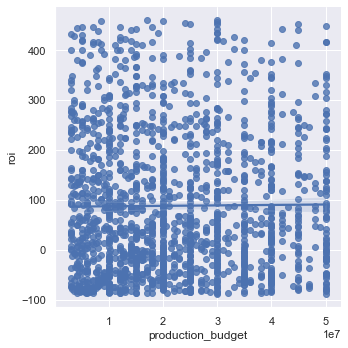

In [127]:
# drop outliers by excluding upper quartile
roi_no_outliers = trailer_df[trailer_df["roi"].between(*trailer_df['roi'].quantile([0.1, 0.85]).tolist())]
budget_no_outliers = roi_no_outliers[roi_no_outliers["production_budget"].between(*roi_no_outliers['production_budget'].quantile([0.1, 0.75]).tolist())]


sns.lmplot('production_budget','roi',data = budget_no_outliers);

## Trailer Views vs. Gross Revenue
### Text Analysis:______

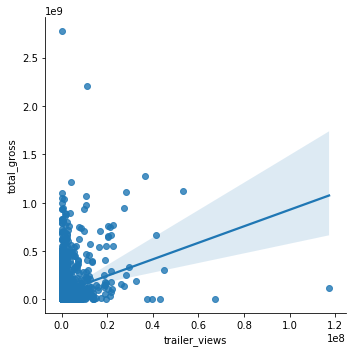

In [18]:
# drop outliers by excluding upper quartile
# roi_no_outliers = trailer_df[trailer_df["roi"].between(*trailer_df['roi'].quantile([0.1, 0.85]).tolist())]
# budget_no_outliers = roi_no_outliers[roi_no_outliers["production_budget"].between(*roi_no_outliers['production_budget'].quantile([0.1, 0.75]).tolist())]


sns.lmplot('trailer_views', 'total_gross', data = trailer_df)

# Question 3: Do Music Scores Contribute to Movie Success?
### Task: Look at how music score ratings compare to movie ratings and ROI
### Data of Interest:
- Composers
- Music Score Rating
- Average Movie Rating
- TMDB rating
- IMDB rating
- ROI

### Datasets: 
- https://www.soundtrack.net/content/reviews/ (not sure if we will end up using this one)
- http://www.movie-wave.net/reviews-by-composer/


## Scrape music reviews page

In [19]:
page = requests.get("http://www.movie-wave.net/reviews-by-title/")
soup = BeautifulSoup(page.content, 'html.parser')
content =soup.find('div', class_="page-content")
p_list = content.findAll('p')

In [20]:
to_df =[]
for p in p_list:
    for a in p.findAll('a'):
        try:
           to_df.append([a.text, a.nextSibling, a.nextSibling.nextSibling.text])
        except:
            pass


## Create DataFrame with Music Ratings

In [21]:
music_df = pd.DataFrame(to_df, columns=['title', 'composer', 'stars'])
music_df['composer'] = music_df['composer'].str[:-7]

In [22]:
stars = list(music_df['stars'])
mapper = {'*****':5, '**** 1/2':4.5,'****':4,'*** 1/2':3.5,'***':3,'** 1/2':2.5,'**':2,'* 1/2':1.5,'*':1}
ratings = list(map(mapper.get, stars))
music_df['music_rating'] = ratings
music_df = music_df.drop('stars',axis=1)
music_df

,title,composer,music_rating
0,10 Cloverfield Lane,Bear McCreary,4.0
1,100 Rifles,Jerry Goldsmith,4.0
2,101 Dalmatians,Michael Kamen,4.5
3,102 Dalmatians,David Newman,4.0
4,"10,000BC",Harald Kloser and Thomas Wander,2.0
...,...,...,...
2294,Zathura,John Debney,4.0
2295,Zero Dark Thirty,Alexandre Desplat,4.0
2296,Zoolander 2,Theodore Shapiro,3.5
2297,Zootopia,Michael Giacchino,2.0


## Merge TMDB Ratings with Budget/ROI table


In [23]:
# Rename columns to specify TMDB, and subset data to only get columns of interest
tmdb = tmdb_raw.merge(budget_concat[['title', 'total_gross','production_budget', 'roi']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb = tmdb.loc[:,['title', 'tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi']]
tmdb.head()

,title,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,33.533,NaN,NaN,NaN
1,How to Train Your Dragon,7.7,7610,28.734,494870992.0,165000000.0,199.92
2,Iron Man 2,6.8,12368,28.515,621156389.0,170000000.0,265.39
3,Toy Story,7.9,10174,28.005,364545516.0,30000000.0,1115.15
4,Inception,8.3,22186,27.920,835524642.0,160000000.0,422.20


## merge in IMDB ratings with above TMDB table

In [24]:
# To retain as much info as possible, joined imdb_ratings with title table rather than title_basics
imdb = imdb_raw.merge(titles_raw,left_on ='tconst', right_on ='title_id')
imdb.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)
imdb = imdb[['title', 'imdb_rating', 'imdb_votes' ]]
ratings = imdb.merge(tmdb, on='title', how='left')
ratings.head()

,title,imdb_rating,imdb_votes,tmdb_rating,tmdb_votes,tmdb_popularity,total_gross,production_budget,roi
0,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
1,Samo Ines,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
2,Just Inès,6.4,20,NaN,NaN,NaN,NaN,NaN,NaN
3,The Legend of Hercules,4.2,50352,4.5,805.0,13.754,58953319.0,70000000.0,-15.78
4,Hércules - A Lenda Começa,4.2,50352,NaN,NaN,NaN,NaN,NaN,NaN


# Final Music X IMDB X TMDB X Revenue Table

In [25]:
final_music = music_df.merge(ratings, on='title', how='inner')

In [26]:
final_music.isnull().sum()

title                   0
composer                0
music_rating           84
imdb_rating             0
imdb_votes              0
tmdb_rating           558
tmdb_votes            558
tmdb_popularity       558
total_gross          1193
production_budget    1401
roi                  1401
dtype: int64

In [27]:
music_imdb = final_music.drop(['tmdb_rating', 'tmdb_votes', 'tmdb_popularity', 'total_gross', 'production_budget', 'roi'], axis=1)
music_imdb.dropna(inplace=True)

In [28]:
music_imdb = music_imdb.sort_values('imdb_rating').dropna()[:-5]

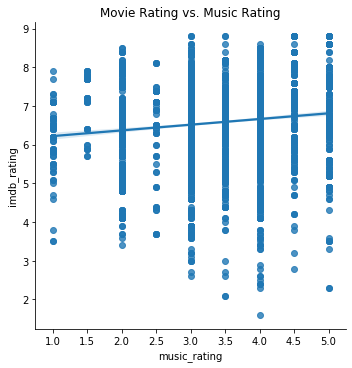

In [29]:
# remove  bottom 5 imdb_outliers
music_imdb = music_imdb.sort_values('imdb_rating').dropna()[:-5]
sns.lmplot('music_rating','imdb_rating',  data = music_imdb);
plt.title('Movie Rating vs. Music Rating');

#### There is a positivve correlation between music ratings and the imdb movie rating. 

### Clean Movie Budget DataFrame and Compute ROI

In [30]:
gross = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
gross['year'] = gross['release_date'].str[-4:].astype(float)
gross['domestic_gross'] = gross['domestic_gross'].str.replace(',', '')
gross['domestic_gross'] = gross['domestic_gross'].str.replace('$', '').astype(float)
gross['production_budget'] = gross['production_budget'].str.replace(',', '')
gross['production_budget'] = gross['production_budget'].str.replace('$', '').astype(float)
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace(',', '')
gross['worldwide_gross'] = gross['worldwide_gross'].str.replace('$', '').astype(float)

In [31]:
gross['ROI'] = (((gross['worldwide_gross'] - gross['production_budget']) / gross['production_budget'] ) * 100)

In [32]:
# renaming and setting index for merging purposes
gross.rename(columns = {'movie': 'original_title'}, inplace=True)
gross.set_index('original_title')

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,ROI
original_title,,,,,,,
Avatar,1,"Dec 18, 2009",425000000.0,760507625.0,2.776345e+09,2009.0,553.257713
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000.0,241063875.0,1.045664e+09,2011.0,154.667286
Dark Phoenix,3,"Jun 7, 2019",350000000.0,42762350.0,1.497624e+08,2019.0,-57.210757
Avengers: Age of Ultron,4,"May 1, 2015",330600000.0,459005868.0,1.403014e+09,2015.0,324.384139
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000.0,620181382.0,1.316722e+09,2017.0,315.369636
...,...,...,...,...,...,...,...
Red 11,78,"Dec 31, 2018",7000.0,0.0,0.000000e+00,2018.0,-100.000000
Following,79,"Apr 2, 1999",6000.0,48482.0,2.404950e+05,1999.0,3908.250000
Return to the Land of Wonders,80,"Jul 13, 2005",5000.0,1338.0,1.338000e+03,2005.0,-73.240000


### Stack Genre DataFrame and Merge with Financial Data

In [33]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw

genre_ugly = genre_raw
genre_ugly['genres'] = genre_ugly['genres'].str.split(',', 3)
genre_unstack = genre_ugly.set_index('original_title').genres.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
genre_unstack.columns = ['original_title', 'genres']

In [34]:
genre_unstack

,original_title,genres
0,Sunghursh,Action
1,Sunghursh,Crime
2,Sunghursh,Drama
3,Ashad Ka Ek Din,Biography
4,Ashad Ka Ek Din,Drama
...,...,...
229545,The Secret of China,War
229546,Kuambil Lagi Hatiku,Drama
229547,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
229548,Dankyavar Danka,Comedy


In [35]:
# Merge with budget table and remove null values
genre_roi = genre_unstack.merge(gross[['original_title', 'ROI']], on='original_title', how='left')
genre_roi.dropna(axis = 0, inplace = True)

In [36]:
genre_roi

,original_title,genres,ROI
32,Foodfight!,Action,-99.836209
33,Foodfight!,Animation,-99.836209
34,Foodfight!,Comedy,-99.836209
51,Mortal Kombat,Action,510.666135
52,Mortal Kombat,Adventure,510.666135
...,...,...,...
229383,Ali,Drama,-19.555994
229632,The Promise,Drama,-88.276203
229699,Sublime,Documentary,-100.000000
229751,Columbus,Comedy,58.644429


### Compiling for Composer Dataframe

In [37]:
# stack column listing movie id for each crew member
crew = crew_raw
crew['directors'] = crew['directors'].str.split(',', 5)
crew_unstack = crew.set_index('tconst').directors.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()
crew_unstack.columns = ['tconst', 'id']

In [38]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw.rename(columns = {'nconst' : 'directors', 'title_id':'tconst'}, inplace=True)
name_basics_raw

name_basics = name_basics_raw
name_basics['primary_profession'] = name_basics['primary_profession'].str.split(',', 5)
name_basics_unstack = name_basics.set_index('directors').primary_profession.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [39]:
name_basics_unstack.columns = ['id', 'job_title']
name_basics.rename(columns={'directors':'id'}, inplace=True)

In [40]:
# Pulling in Data and Matching indices to Merge
titles_raw.rename(columns = {'title_id':'tconst', 'title' : 'original_title'}, inplace=True)
titles_raw

,tconst,ordering,original_title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,NaN,NaN,original,NaN,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,NaN,0.0
331700,tt9880178,1,La atención,NaN,NaN,original,NaN,1.0
331701,tt9880178,2,La atención,ES,NaN,NaN,NaN,0.0


In [41]:
roi_with_title = genre_roi.merge(titles_raw[['original_title', 'tconst']], on='original_title', how='inner')

In [42]:
roi_with_title

,original_title,genres,ROI,tconst
0,Foodfight!,Action,-99.836209,tt0249516
1,Foodfight!,Action,-99.836209,tt0249516
2,Foodfight!,Action,-99.836209,tt0249516
3,Foodfight!,Action,-99.836209,tt0249516
4,Foodfight!,Action,-99.836209,tt0249516
...,...,...,...,...
43193,Darkness,Sci-Fi,224.615151,tt4341750
43194,Darkness,Sci-Fi,224.615151,tt3961040
43195,Traitor,Action,26.737391,tt1995390
43196,Traitor,Drama,26.737391,tt1995390


In [43]:
composer = name_basics_unstack[name_basics_unstack['job_title'] == 'composer']

In [44]:
composers = crew_unstack.merge(composer[['id', 'job_title']], on='id', how='left')
composers.dropna(inplace=True)
composers.set_index('id', inplace=True)

In [45]:
composers_names = composer.merge(name_basics[['id', 'primary_name']], on='id', how='left')
composers_names.set_index('primary_name')

,id,job_title
primary_name,,
Joseph Bauer,nm0061865,composer
Stevie Be-Zet,nm0063432,composer
Jeff Beal,nm0063618,composer
Gavin Bellour,nm0069225,composer
Jorge Ben Jor,nm0069990,composer
...,...,...
Oscar Martorell,nm9786484,composer
Shine Issai,nm9927305,composer
Ifthi,nm9942831,composer


In [46]:
crew = crew_unstack.merge(name_basics_raw[['id', 'primary_name']], on='id', how='left')

In [47]:
roi_crew_genre = roi_with_title.merge(crew[['tconst', 'primary_name']], on='tconst', how='left')
roi_crew_genre.drop_duplicates(inplace=True)
roi_crew_genre.set_index('primary_name')

,original_title,genres,ROI,tconst
primary_name,,,,
Lawrence Kasanoff,Foodfight!,Action,-99.836209,tt0249516
Lawrence Kasanoff,Foodfight!,Animation,-99.836209,tt0249516
Lawrence Kasanoff,Foodfight!,Comedy,-99.836209,tt0249516
Simon McQuoid,Mortal Kombat,Action,510.666135,tt0293429
Simon McQuoid,Mortal Kombat,Adventure,510.666135,tt0293429
...,...,...,...,...
Gijsbert Tukker,Darkness,Sci-Fi,224.615151,tt4341750
Jug Radivojevic,Darkness,Sci-Fi,224.615151,tt3961040
Susanna White,Traitor,Action,26.737391,tt1995390


In [48]:
composer_ = roi_crew_genre.merge(composers_names[['job_title', 'primary_name']], on='primary_name', how='inner')

In [49]:
composer_df = composer_.merge(imdb_raw[['tconst', 'averagerating']], on='tconst', how='left')
composer_df.rename(columns={'primary_name': 'composer'}, inplace=True)
composer_df.set_index('composer', inplace=True)

In [50]:
composer_df.ROI.mean()

940.8412287072595

In [51]:
ratings.roi.mean()

462.7795186964304

##### Composer on average brings in near double




### did a movie with a composer do better than the overall average ratings?

## why are the ticks different

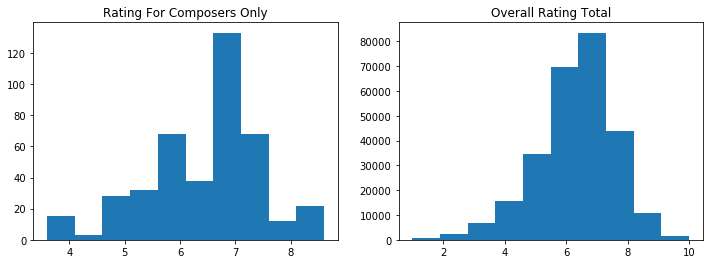

In [52]:
figure, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Rating For Composers Only')
ax[0].set_xlabel('')
ax[0].set_ylabel('')

y = composer_df.averagerating

ax[0].hist(y);

ax[1].set_title('Overall Rating Total')
ax[1].set_xlabel('')
ax[1].set_ylabel('')

y = ratings.imdb_rating

ax[1].hist(y);

In [53]:
#### we should get the mean and standard dev
composer_df['averagerating'].mean()

6.389737470167065

In [54]:
ratings['imdb_rating'].mean()

6.2688522154496455

In [55]:
composer_df['averagerating'].std()

1.0393523368884579

In [56]:
ratings['imdb_rating'].std()

1.2575963534615557

### NEED INSIGHTS -------
#### mean is slightly higher and std dev is lower for the composers than overall

### Trying to get side by side bars

In [57]:
N = 23
mean = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

std = genre_roi.groupby(['genres'])['ROI'].std()
z = q.index

ind = np.arange(N)

figure, ax = plt.subplots(figsize = (20,7))

ax.set_title('Average ROI  vs Std For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(ind + width / 2, rotation=90)

width = .5

plt.bar(ind, mean, color='green')
plt.bar(ind + width, std, color='blue')

NameError: name 'q' is not defined

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].mean()
x = y.index

figure, ax = plt.subplots(figsize = (8,5))

ax.set_title('ROI Standard Deviation For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].std()
x = y.index

figure, ax = plt.subplots(figsize = (8,5))

ax.set_title('ROI Standard Deviation For Movie Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('ROI (percentage)')

plt.xticks(rotation=90)

ax.bar(x, y, color='green');

### or settle for this boring one // just the mean one above

In [ ]:
y = genre_roi.groupby(['genres'])['ROI'].std()
x = genre_roi.groupby(['genres'])['ROI'].mean()

figure, ax = plt.subplots(figsize = (5,3))

ax.set_title('ROI For Movie Genres')
ax.set_xlabel('Mean')
ax.set_ylabel('Standard Deviation')

plt.xticks(rotation=90)

ax.scatter(x, y, color='green');



#### The genres with the top 3 ROI's also have the highest standard deviation.

In [ ]:
### could look into how much better the remake did  for musicals -- wait only 6 remakes though